<h3 style = "font-size:40px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049; text-align: center; border-radius: 5px 5px; padding: 5px">Shadow deployment of ML models with Amazon SageMaker</h3>

AWS has announced the shadow model deployment strategy support in Amazon SageMaker in `AWS re:Invent 2022`. Shadow testing helps us to minimize the risk of deploying a low performing model, minimize the downtime and monitor the model performance of the new model version for a period of time and can rollback if there is an issue with the new version.

<img src = "./img/shadow_deployment.jpg" >

**Shadow testing features**
1. Run multiple model versions in parallel with one serving live traffic.
2. Validate the new model version (shadow variant) without impact.
3. Production variant accepts the request and serves the prediction response.
4. Shadow variant will accept a user-defined portion of the requests, if required we can capture the response of shadow variant in S3 but it will not serve prediction responses to consumers.

Once we are comfortable with the shadow variant then we can promote that shadow variant as a production variant and serve predictions from that model.

**Shadow or challenger deployment use cases**
1. Evaluate the model performance metrics such as model latency, overhead latency, model errors and invocation 5xx errors etc.
2. Evaluate the model evaluation metrics such accuracy, f1 score, precision, recall and MSE etc.
3. Evaluate the changes to model serving infrastructure like installing new dependencies, upgrading the model serving framework versions and container versions etc.

If the new or updated model is performing better than the existing production model wrt above use cases then we can promote a new model as a production model.

In `AWS re:Invent 2022`, they demonstrated the capabilities of shadow testing by using SageMaker console and SageMaker inference APIs for the first use case. We often improve the existing production models by collecting feedback from customers, retraining a model with new samples of data or by making use of model monitoring (model and data drift) components. So I would like to demonstrate how we can utilize the shadow testing feature in the second use case.

In my [previous post](https://medium.com/analytics-vidhya/aws-sagemaker-train-deploy-and-update-a-hugging-face-bert-model-eeefc8211368), I have discussed how to fine-tune a HuggingFace BERT model on disaster tweets classification dataset using on-demand and spot instances, deploy that model on a real-time endpoint and update that endpoint as well.

<a id = '0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #007580; color : #fed049; border-radius: 5px 5px; text-align:center; font-weight: bold" > Table of Contents</h2>

1. [Prepare model artifacts](#1.0)
2. [Deploy tweet-classifier-v1 model (as production variant)](#2.0)
3. [Get predictions from tweet-classifier-v1 model](#3.0)
4. [Deploy tweet-classifier-v2 model (as shadow variant)](#4.0)
5. [Get predictions from tweet-classifier-v2 model](#5.0)
6. [View production variant captured data from S3](#6.0)
7. [View shadow variant captured data from S3](#7.0)
8. [Compare the model evaluation metrics](#8.0)
9. [Promote the shadow variant as a production variant](#9.0)
10. [Clean up](#10.0)
11. [References and acknowledgements](#11.0)

<a id = '1.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 1. Prepare model artifacts </h2>

Let’s deploy a HuggingFace BERT model as a production variant which is fine-tuned with two epochs and consider a shadow variant which is fine-tuned with three epochs.

In [2]:
# Fine-tuned with 2 epochs
model_v1_path = "s3://sagemaker-xx-xxxx-x-xxxxxxxxxxxx/sagemaker/social-media/models/model_v1/model_v1.tar.gz"
# Fine-tuned with 3 epochs
model_v2_path = "s3://sagemaker-xx-xxxx-x-xxxxxxxxxxxx/sagemaker/social-media/models/model_v2/model_v2.tar.gz"

<a id = '2.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 2. Deploy tweet-classifier-v1 model (as production variant) </h2>

In [3]:
import os
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_session.region_name
sm_boto3 = boto3.client("sagemaker")

In [4]:
from time import gmtime, strftime

def name_with_timestamp(name):
    return '{}-{}'.format(name, strftime('%Y-%m-%d-%H-%M-%S', gmtime()))

In [ ]:
tweet_cls_v1_model_name    = name_with_timestamp('tweet-classifier-v1-model')
tweet_cls_v1_epc_name      = name_with_timestamp('tweet-classifier-v1-epc')
tweet_cls_endpoint_name    = name_with_timestamp('tweet-classifier-ep')

production_variant_name = "production"

# Create a tweet-classifier-v1 model as production variant
from sagemaker import get_execution_role

image_uri = sagemaker.image_uris.retrieve(
    framework="pytorch",
    region=region,
    py_version="py38",
    image_scope="inference",
    version="1.9",
    instance_type="ml.m5.xlarge",
)

primary_container = {'Image': image_uri, 'ModelDataUrl': model_v1_path,
    'Environment': {
        'SAGEMAKER_PROGRAM': 'train_deploy.py',
        'SAGEMAKER_REGION': region,
        'SAGEMAKER_SUBMIT_DIRECTORY': model_v1_path
    }
}

create_model_response = sm_boto3.create_model(ModelName = tweet_cls_v1_model_name, ExecutionRoleArn = get_execution_role(), PrimaryContainer = primary_container)
print('ModelArn= {}'.format(create_model_response['ModelArn']))

# Create an endpoint config
endpoint_config_response = sm_boto3.create_endpoint_config(EndpointConfigName = tweet_cls_v1_epc_name,
    ProductionVariants=[
        {
        'InstanceType':'ml.m5.xlarge',
        'InitialInstanceCount':1,
        'ModelName':tweet_cls_v1_model_name,
        'VariantName':production_variant_name,
        'InitialVariantWeight':1
        }
    ])

print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

# Create an endpoint
endpoint_params = {'EndpointName': tweet_cls_endpoint_name, 'EndpointConfigName': tweet_cls_v1_epc_name}

endpoint_response = sm_boto3.create_endpoint(EndpointName=tweet_cls_endpoint_name, EndpointConfigName=tweet_cls_v1_epc_name)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

<a id = '3.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 3. Get predictions from tweet-classifier-v1 model </h2>

In [6]:
import boto3
import json

sm = boto3.client('sagemaker-runtime')

payload = ["Just witnessed a beautiful sunset on my evening walk. Sometimes it's the little things that can make our day. #sunset #beauty"]
payload = json.dumps(payload)
response = sm.invoke_endpoint(EndpointName=tweet_cls_endpoint_name, Body=payload, ContentType='application/json')

result = json.loads(response['Body'].read())
print(result)

{'prob_score': '0.7350', 'label': 'Not a disaster'}


<a id = '4.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 4. Deploy tweet-classifier-v2 model (as shadow variant) </h2>

Let’s deploy a tweet-classifier-v2 model as a shadow variant which is fine-tuned with three epochs.

We capture the 100% request and response of both production and shadow variants using [Data Capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html) options by providing S3 URI. As per settings below, SageMaker routes the 50% (InitialVariantWeight=0.5) copy of the inference requests received by the production variant to the shadow variant.

In [ ]:
tweet_cls_v2_model_name      = name_with_timestamp('tweet-classifier-v2-model')
tweet_cls_v2_shadow_epc_name = name_with_timestamp('tweet-classifier-v2-shadow-epc')
shadow_variant_name = "shadow"

# Create a tweet-classifier-v2 model as shadow variant
primary_container = {'Image': image_uri, 'ModelDataUrl': model_v2_path,
    'Environment': {
        'SAGEMAKER_PROGRAM': 'train_deploy.py',
        'SAGEMAKER_REGION': region,
        'SAGEMAKER_SUBMIT_DIRECTORY': model_v2_path
    }
}

create_model_response = sm_boto3.create_model(ModelName = tweet_cls_v2_model_name, ExecutionRoleArn = get_execution_role(), PrimaryContainer = primary_container)
print('ModelArn= {}'.format(create_model_response['ModelArn']))

# Create an endpoint config with production and shadow variants
data_capture_prefix = "sagemaker/social-media/models"

endpoint_config_response = sm_boto3.create_endpoint_config(
    EndpointConfigName = tweet_cls_v2_shadow_epc_name,
    ProductionVariants=[
        {
        'InstanceType':'ml.m5.xlarge',
        'InitialInstanceCount':1,
        'ModelName':tweet_cls_v1_model_name,
        'VariantName':production_variant_name,
        'InitialVariantWeight':1
        }
    ],
    # Type: Array of ShadowProductionVariants 
    ShadowProductionVariants = [
        {
         "ModelName": tweet_cls_v2_model_name,
         'VariantName':shadow_variant_name,
         "InitialInstanceCount": 1,
         "InitialVariantWeight": 0.5,
         "InstanceType": "ml.m5.xlarge"
        }
   ],
   DataCaptureConfig={
        'EnableCapture': True,
        'InitialSamplingPercentage': 100,
        'DestinationS3Uri': "s3://{}/{}".format(bucket, data_capture_prefix),
        'CaptureOptions': [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}],
        'CaptureContentTypeHeader': {'JsonContentTypes': ['application/json']}
    })

print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

# Update an endpoint with shadow endpoint config
endpoint_params = {'EndpointName': tweet_cls_endpoint_name, 'EndpointConfigName': tweet_cls_v2_shadow_epc_name}

endpoint_response = sm_boto3.update_endpoint(EndpointName=tweet_cls_endpoint_name, EndpointConfigName=tweet_cls_v2_shadow_epc_name)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Verify the production and shadow variants settings in AWS console.

<img src = "./img/prod_shadow_variants.jpg" >

<a id = '5.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 5. Get predictions from tweet-classifier-v2 model </h2>

In [8]:
input = [
    "Exciting news! Our team has just launched a new product that is going to change the game in the industry. Stay tuned for more details. #innovation #success",
    "Happy to announce that we've hit a new milestone - 1 million followers on our social media page! Thank you all for your support. #milestone #grateful",
    "Just witnessed a beautiful sunset on my evening walk. Sometimes it's the little things that can make our day. #sunset #beauty",
    "The new Star Wars movie is finally out and it's amazing! So much action and plot twists, a must see for any fan. #StarWars #MovieNight",
    "Just finished a great book, definitely recommend it to anyone who loves a good thriller. Can't wait to start the next one. #bookrecommendation #reading",
    "Devastating wildfires continue to ravage the western United States, with thousands of acres burned and entire communities forced to evacuate. #wildfire #disaster",
    "Hurricane Maria makes landfall in Puerto Rico, causing widespread damage and power outages. Our thoughts are with those affected. #hurricane #disaster",
    "Breaking news: a major earthquake strikes the central coast of Chile, measuring 8.3 on the Richter scale. #earthquake #disaster",
    "Flash floods hit the midwest, leaving several towns underwater and causing significant damage to infrastructure. #flood #disaster",
    "Tropical Storm Eta causes widespread flooding and landslides in Central America, leaving many dead and missing. #tropicalstorm #disaster"
]

sm = boto3.client('sagemaker-runtime')

for i in range(len(input)):
    payload = json.dumps(input[i])
    response = sm.invoke_endpoint(EndpointName=tweet_cls_endpoint_name, Body=payload, ContentType='application/json')
    
    result = json.loads(response['Body'].read())
    print(result)

{'prob_score': '0.8252', 'label': 'Not a disaster'}
{'prob_score': '0.8272', 'label': 'Not a disaster'}
{'prob_score': '0.7350', 'label': 'Not a disaster'}
{'prob_score': '0.8160', 'label': 'Not a disaster'}
{'prob_score': '0.8111', 'label': 'Not a disaster'}
{'prob_score': '0.8492', 'label': 'Real disaster'}
{'prob_score': '0.8494', 'label': 'Real disaster'}
{'prob_score': '0.8465', 'label': 'Real disaster'}
{'prob_score': '0.8507', 'label': 'Real disaster'}
{'prob_score': '0.8502', 'label': 'Real disaster'}


<a id = '6.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 6. View production variant captured data from S3 </h2>

Note: It takes a few minutes for the capture data to appear in S3

In [ ]:
# View Production variant captured data
import boto3

s3_client = boto3.Session().client('s3')

current_endpoint_capture_prefix = "{}/{}/{}".format(data_capture_prefix, tweet_cls_endpoint_name, production_variant_name)
result = s3_client.list_objects(Bucket=bucket, Prefix=current_endpoint_capture_prefix)
prod_var_capture_files = [capture_file.get("Key") for capture_file in result.get("Contents")]
print("Found Production Variant Capture Files:")
print("\n ".join(prod_var_capture_files))

In [16]:
def get_obj_body(obj_key):
    return s3_client.get_object(Bucket=bucket, Key=obj_key).get('Body').read().decode("utf-8")

prod_var_capture_file = get_obj_body(prod_var_capture_files[-1])
print(prod_var_capture_file[:2000])

{"captureData":{"endpointInput":{"observedContentType":"application/json","mode":"INPUT","data":"\"Exciting news! Our team has just launched a new product that is going to change the game in the industry. Stay tuned for more details. #innovation #success\"","encoding":"JSON"},"endpointOutput":{"observedContentType":"application/json","mode":"OUTPUT","data":"{\"prob_score\": \"0.8252\", \"label\": \"Not a disaster\"}","encoding":"JSON"}},"eventMetadata":{"eventId":"9d66e263-19cd-40e9-ad08-40cb5d1026ef","inferenceTime":"2023-01-29T13:27:55Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"application/json","mode":"INPUT","data":"\"Happy to announce that we've hit a new milestone - 1 million followers on our social media page! Thank you all for your support. #milestone #grateful\"","encoding":"JSON"},"endpointOutput":{"observedContentType":"application/json","mode":"OUTPUT","data":"{\"prob_score\": \"0.8272\", \"label\": \"Not a disaster\"}","encoding":"JSON"}

In [17]:
# Print prouduction variant captured request and response
print(json.dumps(json.loads(prod_var_capture_file.split('\n')[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/json",
      "mode": "INPUT",
      "data": "\"Exciting news! Our team has just launched a new product that is going to change the game in the industry. Stay tuned for more details. #innovation #success\"",
      "encoding": "JSON"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "{\"prob_score\": \"0.8252\", \"label\": \"Not a disaster\"}",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "9d66e263-19cd-40e9-ad08-40cb5d1026ef",
    "inferenceTime": "2023-01-29T13:27:55Z"
  },
  "eventVersion": "0"
}


Notice that SageMaker generates an `eventId` for each invocation which helps in analysis.

Let’s convert the production variant captured data into pandas dataframe.

In [40]:
# Convert the production variant captured data into pandas dataframe
prod_input_list = []
for i in range(len(prod_var_capture_file.split('\n'))):
    if not len(prod_var_capture_file.split('\n')[i]) == 0:
        prod_input = {}
        prod_input["input"] = json.loads(prod_var_capture_file.split('\n')[i])["captureData"]["endpointInput"]["data"]
        data = json.loads(json.loads(prod_var_capture_file.split('\n')[i])["captureData"]["endpointOutput"]["data"])
        prod_input["prod_output"] = data["label"]
        prod_input["prod_prob_score"] = float(data["prob_score"])
        prod_input["eventId"] = json.loads(prod_var_capture_file.split('\n')[i])["eventMetadata"]["eventId"]
        prod_input_list.append(prod_input)

from pandas import json_normalize
prod_var_df = json_normalize(prod_input_list)
prod_var_df

,input,prod_output,prod_prob_score,eventId
0,"""Exciting news! Our team has just launched a n...",Not a disaster,0.8252,9d66e263-19cd-40e9-ad08-40cb5d1026ef
1,"""Happy to announce that we've hit a new milest...",Not a disaster,0.8272,95512f59-6bf9-4e0f-a337-968429d92bd3
2,"""Just witnessed a beautiful sunset on my eveni...",Not a disaster,0.7350,51b3f028-72ab-46d8-9de9-c39e5c42f7be
3,"""The new Star Wars movie is finally out and it...",Not a disaster,0.8160,3f6af014-49c7-44bb-8f4a-c3deb31fba89
4,"""Just finished a great book, definitely recomm...",Not a disaster,0.8111,a698d805-8938-43cd-9545-b8b02bd018f5
5,"""Devastating wildfires continue to ravage the ...",Real disaster,0.8492,1e19292b-824f-424a-b6ea-72ead2d9a3bf
6,"""Hurricane Maria makes landfall in Puerto Rico...",Real disaster,0.8494,26ceca96-ea62-4758-b459-bcbabda97767
7,"""Breaking news: a major earthquake strikes the...",Real disaster,0.8465,212613f7-d2f8-4619-8339-febd4535f1ca
8,"""Flash floods hit the midwest, leaving several...",Real disaster,0.8507,2e5c0d88-236c-4648-9c45-0e4539b893fa
9,"""Tropical Storm Eta causes widespread flooding...",Real disaster,0.8502,605c346f-efda-4598-884b-9f16bf97f2b4


<a id = '7.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 7. View shadow variant captured data from S3 </h2>

In [25]:
# View Shadow variant captured data
current_endpoint_capture_prefix = "{}/{}/{}".format(data_capture_prefix, tweet_cls_endpoint_name, shadow_variant_name)
result = s3_client.list_objects(Bucket=bucket, Prefix=current_endpoint_capture_prefix)
shadow_var_capture_files = [capture_file.get("Key") for capture_file in result.get("Contents")]
print("Found Production Variant Capture Files:")
print("\n ".join(shadow_var_capture_files))

def get_obj_body(obj_key):
    return s3_client.get_object(Bucket=bucket, Key=obj_key).get('Body').read().decode("utf-8")

shadow_var_capture_file = get_obj_body(shadow_var_capture_files[-1])
print(shadow_var_capture_file[:2000])

{"captureData":{"endpointInput":{"observedContentType":"application/json","mode":"INPUT","data":"\"Happy to announce that we've hit a new milestone - 1 million followers on our social media page! Thank you all for your support. #milestone #grateful\"","encoding":"JSON"},"endpointOutput":{"observedContentType":"application/json","mode":"OUTPUT","data":"{\"prob_score\": \"0.8586\", \"label\": \"Not a disaster\"}","encoding":"JSON"}},"eventMetadata":{"eventId":"95512f59-6bf9-4e0f-a337-968429d92bd3","invocationSource":"ShadowExperiment","inferenceTime":"2023-01-29T13:27:56Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"application/json","mode":"INPUT","data":"\"Just witnessed a beautiful sunset on my evening walk. Sometimes it's the little things that can make our day. #sunset #beauty\"","encoding":"JSON"},"endpointOutput":{"observedContentType":"application/json","mode":"OUTPUT","data":"{\"prob_score\": \"0.8185\", \"label\": \"Not a disaster\"}","encoding"

In [26]:
# Print shadow variant captured request and response
print(json.dumps(json.loads(shadow_var_capture_file.split('\n')[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/json",
      "mode": "INPUT",
      "data": "\"Happy to announce that we've hit a new milestone - 1 million followers on our social media page! Thank you all for your support. #milestone #grateful\"",
      "encoding": "JSON"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "{\"prob_score\": \"0.8586\", \"label\": \"Not a disaster\"}",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "95512f59-6bf9-4e0f-a337-968429d92bd3",
    "invocationSource": "ShadowExperiment",
    "inferenceTime": "2023-01-29T13:27:56Z"
  },
  "eventVersion": "0"
}


Notice that SageMaker generates an `eventId` and capture `invocationSource` as `ShadowExperiment` which helps in identifying the captured data from shadow variant and production variant.

In [ ]:
# Convert the shadow variant captured data into pandas dataframe
shadow_input_list = []
for i in range(len(shadow_var_capture_file.split('\n'))):
    if not len(shadow_var_capture_file.split('\n')[i]) == 0:
        shadow_input = {}
        data = json.loads(json.loads(shadow_var_capture_file.split('\n')[i])["captureData"]["endpointOutput"]["data"])
        shadow_input["shadow_output"] = data["label"]
        shadow_input["shadow_prob_score"] = float(data["prob_score"])
        shadow_input["eventId"] = json.loads(shadow_var_capture_file.split('\n')[i])["eventMetadata"]["eventId"]
        shadow_input_list.append(shadow_input)

shadow_var_df = json_normalize(shadow_input_list)
shadow_var_df

<a id = '8.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 8. Compare the model evaluation metrics </h2>

In [43]:
import pandas as pd
final_df = pd.merge(prod_var_df, shadow_var_df, on='eventId', how='right')
final_df

,input,prod_output,prod_prob_score,eventId,shadow_output,shadow_prob_score
0,"""Happy to announce that we've hit a new milest...",Not a disaster,0.8272,95512f59-6bf9-4e0f-a337-968429d92bd3,Not a disaster,0.8586
1,"""Just witnessed a beautiful sunset on my eveni...",Not a disaster,0.7350,51b3f028-72ab-46d8-9de9-c39e5c42f7be,Not a disaster,0.8185
2,"""Just finished a great book, definitely recomm...",Not a disaster,0.8111,a698d805-8938-43cd-9545-b8b02bd018f5,Not a disaster,0.8570
3,"""Flash floods hit the midwest, leaving several...",Real disaster,0.8507,2e5c0d88-236c-4648-9c45-0e4539b893fa,Real disaster,0.8767
4,"""Tropical Storm Eta causes widespread flooding...",Real disaster,0.8502,605c346f-efda-4598-884b-9f16bf97f2b4,Real disaster,0.8718


In [45]:
final_df = final_df.assign(prob_score_diff=final_df['shadow_prob_score'] - final_df['prod_prob_score'])
final_df

,input,prod_output,prod_prob_score,eventId,shadow_output,shadow_prob_score,prob_score_diff
0,"""Happy to announce that we've hit a new milest...",Not a disaster,0.8272,95512f59-6bf9-4e0f-a337-968429d92bd3,Not a disaster,0.8586,0.0314
1,"""Just witnessed a beautiful sunset on my eveni...",Not a disaster,0.7350,51b3f028-72ab-46d8-9de9-c39e5c42f7be,Not a disaster,0.8185,0.0835
2,"""Just finished a great book, definitely recomm...",Not a disaster,0.8111,a698d805-8938-43cd-9545-b8b02bd018f5,Not a disaster,0.8570,0.0459
3,"""Flash floods hit the midwest, leaving several...",Real disaster,0.8507,2e5c0d88-236c-4648-9c45-0e4539b893fa,Real disaster,0.8767,0.0260
4,"""Tropical Storm Eta causes widespread flooding...",Real disaster,0.8502,605c346f-efda-4598-884b-9f16bf97f2b4,Real disaster,0.8718,0.0216


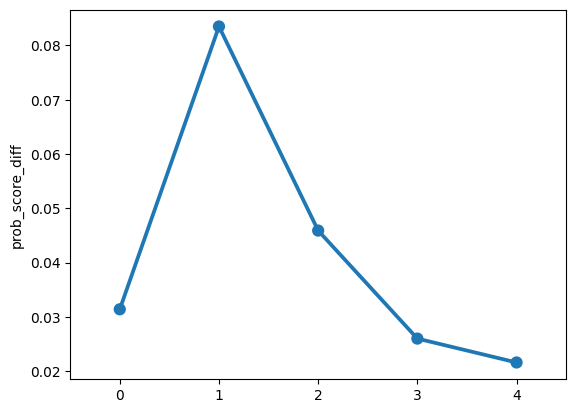

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pointplot(
    x=final_df.index, 
    y=final_df.prob_score_diff, 
    data=final_df);

plt.show()

We can observe that shadow variant (BERT model fine-tuned with 3 epochs) results are better than existing production variant (BERT model fine-tuned with 2 epochs) hence we can promote shadow variant as a production variant.

Note: We can also leverage the Canary deployment strategy even after completing the shadow testing.

<a id = '9.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 9. Promote the shadow variant as a production variant </h2>

In [ ]:
tweet_cls_v2_prod_epc_name = name_with_timestamp('tweet-classifier-v2-prod-epc')

# Create an endpoint config with production variant
endpoint_config_response = sm_boto3.create_endpoint_config(
    EndpointConfigName = tweet_cls_v2_prod_epc_name,
    ProductionVariants=[
        {
        'InstanceType':'ml.m5.xlarge',
        'InitialInstanceCount':1,
        'ModelName':tweet_cls_v2_model_name,
        'VariantName':production_variant_name,
        'InitialVariantWeight':1
        }
    ])

print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

# Update an endpoint with production endpoint config
endpoint_params = {'EndpointName': tweet_cls_endpoint_name, 'EndpointConfigName': tweet_cls_v2_prod_epc_name}
endpoint_response = sm_boto3.update_endpoint(**endpoint_params)

<a id = '10.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 10. Clean up </h2>

In [ ]:
sm_boto3.delete_endpoint(EndpointName=tweet_cls_endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=tweet_cls_v1_epc_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=tweet_cls_v2_shadow_epc_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=tweet_cls_v2_prod_epc_name)
sm_boto3.delete_model(ModelName=tweet_cls_v1_model_name)
sm_boto3.delete_model(ModelName=tweet_cls_v2_model_name)

<a id = '11.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 11. References and acknowledgements </h2>

**References**

- [Introducing Amazon SageMaker support for shadow testing](https://aws.amazon.com/about-aws/whats-new/2022/11/amazon-sagemaker-shadow-testing/)

- [Minimize the production impact of ML model updates with Amazon SageMaker shadow testing](https://aws.amazon.com/blogs/machine-learning/minimize-the-production-impact-of-ml-model-updates-with-amazon-sagemaker-shadow-testing/)


**Acknowledgements**

Special thanks to the AWS SageMaker team (Raghu Ramesha, Qiyun Zhao, Qingwei Li, and Tarun Sairam) for their contribution in introducing the SageMaker support for shadow testing.


I would love to hear your suggestions on further improvements and also welcome your code contribution to the [github repo](https://github.com/Vinayaks117/AWS-SageMaker-Examples.git)